# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5 Phase 2


---
__Name:__  *Your Name Goes Here*   
__Class:__ MIDS w261 (Section *Your Section Goes Here*, e.g., Fall 2016 Group 1)     
__Email:__  *Your UC Berkeley Email Goes Here*@iSchool.Berkeley.edu     
__StudentId__  123457    __End of StudentId__     
__Week:__   5.5

__NOTE:__ please replace `1234567` with your student id above      
__Due Time:__ HW is due the Thursday of the following week by 8AM (West coast time).

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as Altiscale's PaaS or on AWS) and is due Thursday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the Altiscale cluster and will be due Thursday of the following week by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. 

# Datasets

For Phase 2 you will first use the small datasets from phase 1 to systems test your code in the cloud. Then you will test your code on 1 file and then 20 files before running the full (191 file) Google n-gram dataset.

__Small data for systems tests__

In [1]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [2]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


__Paths to Main data in HDFS on Altiscale__

In [29]:
TEST_1 = "/user/winegarj/data/1_test"
TEST_20 = "/user/winegarj/data/20_test"
FULL_DATA = "/user/winegarj/data/full" 


# Set - Up for Phase 2
Before you can run your simlarity analysis on the full Google n-gram dataset you should confirm that the code your wrote in Phase 1 works on the cloud. In the space below, copy the code for your three jobs from Phase 1 (`buildStripes.py`, `invertedIndex.py`, `similarity.py`) and rerun your  atlas-boon systems tests on Altiscale (i.e. ** the cloud**). NOTE: _you may end up modifying this code when you get to 5.7, that's fine._

### `buildStripes.py`

In [4]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict

class MRbuildStripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
    #OUTPUT_PROTOCOL = RawValueProtocol # Not strictly necessary, but the output is prettier this way


    
    stripe = defaultdict(int)
    current_word = None
    total_count = 0
    
    def mapper(self, _, line):
        words, count, pages_count, books_count = line.strip().split("\t")
        words = words.lower().split(" ")
        self.stripe = defaultdict(int)
        for word1 in words:
            for word2 in words:
                if (word1 != word2):
                    self.stripe[word2] = int(count)
            final_string = ""
            for word3, count3 in self.stripe.iteritems():
                final_string +=  "\t" + word3 + ":" + str(count3)
            yield word1, final_string
        

    def reducer(self, word, lines):
        if (word == self.current_word):
            for line in lines:
                couples = line.strip().split("\t")
                for couple in couples:
                    word2, count = couple.split(":")
                    if (word2 != word):
                        self.stripe[word2] += int(count)
        else:
            if (self.current_word):
                yield self.current_word, self.stripe
            self.current_word = word
            self.stripe = defaultdict(int)
            for line in lines:
                couples = line.strip().split("\t")
                for couple in couples:
                    word2, count = couple.split(":")
                    if (word2 != word):
                        self.stripe[word2] += int(count)   
 
            
    def reducer_final(self):
        if (self.current_word):
            yield self.current_word, self.stripe
        
    def steps(self):
        return [MRStep(
                    mapper = self.mapper,
                    reducer = self.reducer,
                    reducer_final = self.reducer_final)]
    
  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
  MRbuildStripes.run()

Overwriting buildStripes.py


### `invertedIndex.py`

In [5]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):
    
  #START SUDENT CODE531_INV_INDEX

    MRJob.SORT_VALUES = True
    
    words = []
    cur_word = None
    cur_count = 0
    
    def mapper(self, _, line):
        word1, stripe = line.strip().split('\t')
        word1 = word1.strip("\"")
        stripe = json.loads(stripe)
        for word2 in stripe:
            yield (word2,word1), len(stripe)

        

    def reducer(self, words, count):
        word1 = words[0]
        word2 = words[1]
        cur_count = [c for c in count][0]
        if (word1 == self.cur_word):
            #same word, add to the list
            self.words.append((word2,cur_count))
        else:
            # it is a new word
            if (self.cur_word):
                yield self.cur_word, self.words
            self.cur_word = word1
            self.words = [(word2,cur_count)]
            
    def reducer_final(self):
        if (self.cur_word):
             yield self.cur_word, self.words
        
    def steps(self):
      
        return [MRStep(
                    mapper = self.mapper,
                    reducer = self.reducer,
                    reducer_final = self.reducer_final)]

  #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run()

Overwriting invertedIndex.py


### `similarity.py`

In [6]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
  
  #START SUDENT CODE531_SIMILARITY
    
    MRJob.SORT_VALUES = True
    
    def mapper(self, _, line):
        key, stripe = line.split("\t")
        stripe = json.loads(stripe)
        for couple_pair in itertools.combinations(stripe, 2):
            (word1,card1),(word2,card2) = couple_pair
            yield (word1,word2), (1,card1,card2)
        
        
    def reducer(self, words, counts):
        word1 = words[0]
        word2 = words[1]
        cur_count = 0
        for count in counts:
            card1 = int(count[1])
            card2 = int(count[2])
            cur_count += int(count[0])
        jaccard = cur_count / (card1 + card2 - cur_count)
        cosine = cur_count / np.sqrt(card1 * card2)
        avg = (cosine + jaccard) / 2
        yield avg, ((word1,word2), cosine, jaccard)
        
    
    def mapper_avgsort(self, avg, line):
        #avg, stripe = line.split("\t")
        #stripe = json.loads(stripe)
        yield float(avg), line
        
    
    JOBCONF = { 'mapred.text.key.comparator.options': '-k1nr'}
    
    def steps(self):
        return [
            MRStep( mapper = self.mapper,
                    reducer = self.reducer),
            MRStep( jobconf = self.JOBCONF,
                    mapper = self.mapper_avgsort)
                ]

  #END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


## atlas-boon systems test

In [7]:
# ADD CELLS HERE
OUTPUT_PATH = "/user/daghan/hw5/atlas-boon/stripes"
!hadoop fs -rm -r {OUTPUT_PATH}
!python buildStripes.py -r hadoop atlas-boon-systems-test.txt --output-dir={OUTPUT_PATH} --no-output

18/03/07 02:32:32 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/atlas-boon/stripes' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes.daghan.20180307.023233.098671
Copying local files to hdfs:///user/daghan/tmp/mrjob/buildStripes.daghan.20180307.023233.098671/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6470747690179931595.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:

In [8]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_stripes_2
!cat system_test_stripes_2

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


In [9]:
OUTPUT_PATH = "/user/daghan/hw5/atlas-boon/index"
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndex.py -r hadoop systems_test_stripes_2 --output-dir={OUTPUT_PATH} --no-output 

18/03/07 02:33:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/atlas-boon/index' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.daghan.20180307.023327.183773
Copying local files to hdfs:///user/daghan/tmp/mrjob/invertedIndex.daghan.20180307.023327.183773/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8843711676065664246.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:

In [10]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_index_2
!cat systems_test_index_2

"atlas"	[["boon", 3], ["dipped", 3]]
"boon"	[["atlas", 2], ["cava", 2], ["dipped", 3]]
"cava"	[["boon", 3], ["dipped", 3]]
"dipped"	[["atlas", 2], ["boon", 3], ["cava", 2]]


In [11]:
OUTPUT_PATH = "/user/daghan/hw5/atlas-boon/similarities"
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py -r hadoop systems_test_index_2 --output-dir={OUTPUT_PATH} --no-output 

18/03/07 02:34:14 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/atlas-boon/similarities' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.daghan.20180307.023415.409943
Copying local files to hdfs:///user/daghan/tmp/mrjob/similarity.daghan.20180307.023415.409943/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Running step 1 of 2..

In [12]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_similarities_2
!cat systems_test_similarities_2

0.5833333333333333	[["boon", "dipped"], 0.6666666666666666, 0.5]	
0.32912414523193156	[["cava", "dipped"], 0.4082482904638631, 0.25]	
0.32912414523193156	[["atlas", "boon"], 0.4082482904638631, 0.25]	
1.0	[["atlas", "cava"], 1.0, 1.0]	
0.32912414523193156	[["atlas", "dipped"], 0.4082482904638631, 0.25]	
0.32912414523193156	[["boon", "cava"], 0.4082482904638631, 0.25]	


# 10-line systems test

In [13]:
# ADD CELLS HERE
OUTPUT_PATH = "/user/daghan/hw5/10-line/stripes"
!hadoop fs -rm -r {OUTPUT_PATH}
!python buildStripes.py -r hadoop \
    googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
    --output-dir={OUTPUT_PATH} --no-output

18/03/07 02:35:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/10-line/stripes' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes.daghan.20180307.023537.832946
Copying local files to hdfs:///user/daghan/tmp/mrjob/buildStripes.daghan.20180307.023537.832946/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7403578810488008410.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:818

In [14]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_stripes_1
!cat systems_test_stripes_1

"a"	{"limited": 55, "female": 447, "general": 92, "sea": 62, "in": 1201, "religious": 59, "george": 92, "biography": 92, "city": 62, "for": 59, "tales": 123, "government": 102, "the": 124, "forms": 116, "wales": 1099, "christmas": 1099, "child's": 1099, "collection": 239, "by": 62, "case": 604, "circumstantial": 62, "of": 895, "study": 604, "bill": 59, "establishing": 59, "narrative": 62, "fairy": 123}
"bill"	{"a": 59, "religious": 59, "for": 59, "establishing": 59}
"biography"	{"a": 92, "of": 92, "george": 92, "general": 92}
"by"	{"a": 62, "city": 62, "the": 62, "sea": 62}
"case"	{"a": 604, "limited": 55, "government": 102, "of": 502, "study": 604, "female": 447, "in": 102}
"child's"	{"a": 1099, "wales": 1099, "christmas": 1099, "in": 1099}
"christmas"	{"a": 1099, "wales": 1099, "child's": 1099, "in": 1099}
"circumstantial"	{"a": 62, "of": 62, "the": 62, "narrative": 62}
"city"	{"a": 62, "the": 62, "by": 62, "sea": 62}
"collection"	{"forms": 116, "of": 239, "fairy": 123, "a": 239, "ta

In [15]:
OUTPUT_PATH = "/user/daghan/hw5/10-line/index"
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndex.py -r hadoop systems_test_stripes_1 --output-dir={OUTPUT_PATH} --no-output 

18/03/07 02:36:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/10-line/index' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.daghan.20180307.023626.664082
Copying local files to hdfs:///user/daghan/tmp/mrjob/invertedIndex.daghan.20180307.023626.664082/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1937769588624129150.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:818

In [16]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_index_1
!cat systems_test_index_1

"a"	[["bill", 4], ["biography", 4], ["by", 4], ["case", 7], ["child's", 4], ["christmas", 4], ["circumstantial", 4], ["city", 4], ["collection", 5], ["establishing", 4], ["fairy", 4], ["female", 4], ["for", 4], ["forms", 3], ["general", 4], ["george", 4], ["government", 4], ["in", 7], ["limited", 4], ["narrative", 4], ["of", 15], ["religious", 4], ["sea", 4], ["study", 7], ["tales", 4], ["the", 7], ["wales", 4]]
"bill"	[["a", 27], ["establishing", 4], ["for", 4], ["religious", 4]]
"biography"	[["a", 27], ["general", 4], ["george", 4], ["of", 15]]
"by"	[["a", 27], ["city", 4], ["sea", 4], ["the", 7]]
"case"	[["a", 27], ["female", 4], ["government", 4], ["in", 7], ["limited", 4], ["of", 15], ["study", 7]]
"child's"	[["a", 27], ["christmas", 4], ["in", 7], ["wales", 4]]
"christmas"	[["a", 27], ["child's", 4], ["in", 7], ["wales", 4]]
"circumstantial"	[["a", 27], ["narrative", 4], ["of", 15], ["the", 7]]
"city"	[["a", 27], ["by", 4], ["sea", 4], ["the", 7]]
"collection"	[["a", 27], ["fairy

In [17]:
OUTPUT_PATH = "/user/daghan/hw5/10-line/similarities"
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py -r hadoop systems_test_index_1 --output-dir={OUTPUT_PATH} --no-output 

18/03/07 02:37:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/10-line/similarities' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.daghan.20180307.023722.436327
Copying local files to hdfs:///user/daghan/tmp/mrjob/similarity.daghan.20180307.023722.436327/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
Running step 1 of 2...
 

In [18]:
!hdfs dfs -cat {OUTPUT_PATH}/part* > systems_test_similarities_1
!cat systems_test_similarities_1

0.197908995868835	[["a", "bill"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "biography"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "by"], 0.28867513459481287, 0.10714285714285714]	
0.3253607473788495	[["a", "case"], 0.4364357804719847, 0.21428571428571427]	
0.197908995868835	[["a", "child's"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "christmas"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "circumstantial"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "city"], 0.28867513459481287, 0.10714285714285714]	
0.2435611645933455	[["a", "collection"], 0.34426518632954817, 0.14285714285714285]	
0.197908995868835	[["a", "establishing"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "fairy"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "female"], 0.28867513459481287, 0.10714285714285714]	
0.197908995868835	[["a", "for"], 0.28

In [19]:
############################################
# Pretty print systems tests
# Note: adjust print formatting if you need to
############################################

import json
for i in range(1,3):
  print '—'*80
  print "Systems test ",i," - Similarity measures"
  print '—'*80
  print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format(
          "average", "pair", "cosine", "jaccard")
  print '-'*80

  with open("systems_test_similarities_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
            line = line.strip()
            avg,stripe = line.split("\t")
            stripe = json.loads(stripe)
            word1 = stripe[0][0]
            word2 = stripe[0][1]
            #for word in words:
            #    print(word)
            print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f}".format(
                float(avg), word1 + " - " + word2, float(stripe[1]), float(stripe[2]))


————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
————————————————————————————————————————————————————————————————————————————————
        average |           pair |         cosine |        jaccard
--------------------------------------------------------------------------------
       0.197909 |       a - bill |       0.288675 |       0.107143
       0.197909 |  a - biography |       0.288675 |       0.107143
       0.197909 |         a - by |       0.288675 |       0.107143
       0.325361 |       a - case |       0.436436 |       0.214286
       0.197909 |    a - child's |       0.288675 |       0.107143
       0.197909 |  a - christmas |       0.288675 |       0.107143
       0.197909 |a - circumstantial |       0.288675 |       0.107143
       0.197909 |       a - city |       0.288675 |       0.107143
       0.243561 | a - collection |       0.344265 |       0.142857
       0.197909 |a - establishing |       0.2

# HW5.6 -Google n-grams EDA

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.6.1 - A. Longest 5-gram (number of characters)

In [20]:
!head -n 5 googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43


In [68]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep


class longest5gram(MRJob):
    
    MRJob.SORT_VALUES = True
    
    # START STUDENT CODE 5.6.1.A
    def mapper1(self, _, line):
        ngram, count, pages_count, books_count =  line.strip().lower().split("\t")
        #ngram = re.findall(r'[a-z]+',ngram)
        yield len(ngram), ngram
   
    def reducer1(self, key, values):
        for value in values:
            yield key, value
        
        
    #JOBCONF = {
    #    'mapreduce.job.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
    #    'mapreduce.partition.keycomparator.options': '-k1nr',
    #    'mapreduce.job.reduces': '1'}

  
            
    def steps(self):
        return [MRStep( #jobconf = self.JOBCONF,
                        mapper=self.mapper1,
                        reducer=self.reducer1)]    
 
    # END STUDENT CODE 5.6.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


__On test data set:__

In [69]:
#!python longest5gram.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > tmp.txt
#!cat tmp.txt

In [39]:
OUTPUT_PATH = "/user/daghan/hw5/test_1"
!hadoop fs -rm -r {OUTPUT_PATH}
!python longest5gram.py -r hadoop hdfs://{TEST_1} \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr" \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_1.txt
!head -n 5 test_1.txt

18/03/07 05:33:04 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/test_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.daghan.20180307.053305.215985
Copying local files to hdfs:///user/daghan/tmp/mrjob/longest5gram.daghan.20180307.053305.215985/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob469202410497389329.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/ti

__ On the 20 files dataset: __

In [72]:
OUTPUT_PATH = "/user/daghan/hw5/test_20"
!hadoop fs -rm -r {OUTPUT_PATH}
!python longest5gram.py -r hadoop hdfs://{TEST_20} \
    --jobconf stream.num.map.output.key.fields=2 \
    --jobconf mapreduce.partition.keypartitioner.options=-k1,1 \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
    --jobconf mapreduce.job.reduces=1 \
    --jobconf partitioner=org.apache.Hadoop.mapred.lib.KeyFieldBasedPartitioner \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_20.txt
!head -n 5 test_20.txt

18/03/07 06:18:48 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/test_20' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.daghan.20180307.061849.170956
Copying local files to hdfs:///user/daghan/tmp/mrjob/longest5gram.daghan.20180307.061849.170956/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3522958349325494080.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/

__On full data set:__

In [ ]:
OUTPUT_PATH = "/user/daghan/hw5/test_full"
!hadoop fs -rm -r {OUTPUT_PATH}
!python longest5gram.py -r hadoop hdfs://{FULL_DATA} \
    --jobconf stream.num.map.output.key.fields=2 \
    --jobconf mapreduce.partition.keypartitioner.options=-k1,1 \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
    --jobconf mapreduce.job.reduces=1 \
    --jobconf partitioner=org.apache.Hadoop.mapred.lib.KeyFieldBasedPartitioner \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_full.txt
!head -n 5 test_full.txt

18/03/07 08:45:41 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/test_full' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.daghan.20180307.084542.062449
Copying local files to hdfs:///user/daghan/tmp/mrjob/longest5gram.daghan.20180307.084542.062449/files/...
Running step 1 of 1...


### Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.6.1 - B. Top 10 most frequent words 

In [119]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    MRJob.SORT_VALUES = True
    
    # START STUDENT CODE 5.6.1.B
    def mapper1(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        words = ngram.split(" ")
        for word in words:
            yield word, int(count)
            
    def combiner1(self, word, counts):
        yield word, sum(counts)
            
    def reducer1(self, word, counts):
        yield word, sum(counts) 
        
    
    def reducer_2_init(self):
        self.count = 0
        
    def reducer2(self, word, counts):
        for count in counts:
            yield word, count
    
    def steps(self):
        JOBCONF_STEP_TWO = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k2,2nr k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(jobconf={'mapreduce.job.reduces':'4'},
                   mapper=self.mapper1,
                   combiner=self.combiner1,
                   reducer=self.reducer1),
            MRStep(reducer=self.reducer2,
                   jobconf=JOBCONF_STEP_TWO)]
            
    
    
    # END STUDENT CODE 5.6.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


__On the test data set:__

In [122]:
#!python mostFrequentWords.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > tmp.txt
#!cat tmp.txt

In [121]:
OUTPUT_PATH = "/user/daghan/hw5/test_1"
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostFrequentWords.py -r hadoop hdfs://{TEST_1} \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_1.B.txt
!head -n 10 test_1.B.txt

18/03/07 07:49:40 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/test_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.daghan.20180307.074941.133450
Copying local files to hdfs:///user/daghan/tmp/mrjob/mostFrequentWords.daghan.20180307.074941.133450/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob9152632569923921711.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:81

__ On the 20 files dataset: __

In [ ]:
OUTPUT_PATH = "/user/daghan/hw5/test_20"
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostFrequentWords.py -r hadoop hdfs://{TEST_20} \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_20.B.txt
!head -n 10 test_20.B.txt

In [103]:
!head -n 10 test_20.B.txt

4447221	"the"
2241510	"the"
2223343	"of"
2223343	"on"
2223343	"basis"
1122196	"of"
1120755	"in"
1120755	"light"
914708	"the"
834037	"a"


__On the full data set:__

In [ ]:
OUTPUT_PATH = "/user/daghan/hw5/test_full"
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostFrequentWords.py -r hadoop hdfs://{FULL_DATA} \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_full.B.txt
!head -n 10 test_full.B.txt

### Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.6.1 - C. 20 Most/Least densely appearing words 

In [137]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.6.1.C
    MRJob.SORT_VALUES = True
    
    def mapper1(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        words = ngram.split(" ")
        for word in words:
            yield word, (int(count), int(p_count))

    def combiner1(self, word, values):
        total_count = 0
        total_p_count = 0
        for value in values:
            total_count += value[0]
            total_p_count += value[1]
        yield word, (total_count, total_p_count)
        
    def reducer1(self, word, values):
        total_count = 0
        total_p_count = 0
        for value in values:
            total_count += value[0]
            total_p_count += value[1]
        yield word, (total_count / total_p_count)
        
    def reducer2(self, word, values):
        for value in values:
            yield word, value
    
    
    def steps(self):
        return [
            MRStep(jobconf={'mapreduce.job.reduces':'4'},
                   mapper=self.mapper1,
                   combiner=self.combiner1,
                   reducer=self.reducer1),
            MRStep(reducer=self.reducer2,
                   jobconf={'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'stream.map.output.field.separator':'\t',
                            'mapreduce.partition.keycomparator.options': '-k2,2nr k1,1',
                            'mapreduce.job.reduces': '1'
                           })
        ]
    # END STUDENT CODE 5.6.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [138]:
!python mostLeastDenseWords.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > tmp.txt
!cat tmp.txt

Using configs in /home/daghan/.mrjob.conf
Creating temp directory /tmp/mostLeastDenseWords.daghan.20180307.081020.061015
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostLeastDenseWords.daghan.20180307.081020.061015/output...
Removing temp directory /tmp/mostLeastDenseWords.daghan.20180307.081020.061015...
"of"	1.0348004094
"general"	1.0222222222
"in"	1.0326741187
"female"	1.0
"for"	1.0
"christmas"	1.0358152686
"religious"	1.0
"bill"	1.0
"biography"	1.0222222222
"limited"	1.0
"narrative"	1.0
"forms"	1.1262135922
"circumstantial"	1.0
"by"	1.0333333333
"wales"	1.0358152686
"fairy"	1.0512820513
"city"	1.0333333333
"case"	1.0
"child's"	1.0358152686
"george"	1.0222222222
"the"	1.0163934426
"study"	1.0
"tales"	1.0512820513
"a"	1.0282931354
"government"	1.0
"collection"	1.0863636364
"establishing"	1.0
"sea"	1.0333333333


In [139]:
OUTPUT_PATH = "/user/daghan/hw5/test_1"
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostLeastDenseWords.py -r hadoop hdfs://{TEST_1} \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_1.C.txt
!head -n 10 test_1.C.txt
!tail -n 10 test_1.C.txt

18/03/07 08:11:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/hw5/test_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.daghan.20180307.081127.762697
Copying local files to hdfs:///user/daghan/tmp/mrjob/mostLeastDenseWords.daghan.20180307.081127.762697/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4041317027189795404.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.co

__ On the 20 files dataset: __

In [ ]:
OUTPUT_PATH = "/user/daghan/hw5/test_20"
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostLeastDenseWords.py -r hadoop hdfs://{TEST_20} \
    --output-dir={OUTPUT_PATH} \
    --no-output
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_20.C.txt
!head -n 10 test_20.C.txt
!tail -n 10 test_20.C.txt

__On the full data set:__

### Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.6.1 - D. Distribution of 5-gram sizes (character length)

In [153]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    # START STUDENT CODE 5.6.1.D
    MRJob.SORT_VALUES = True
    
    def mapper1(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        yield len(ngram), int(count)

    def combiner1(self, key, values):
        yield key, sum(values)
        
        
    def reducer1(self, key, values):
        yield key, sum(values)
   
    def steps(self):
        return [
            MRStep(mapper=self.mapper1,
                   combiner=self.combiner1,
                   reducer=self.reducer1)]
    
    # END STUDENT CODE 5.6.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [155]:
!python distribution.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > tmp.txt
!cat tmp.txt

Using configs in /home/daghan/.mrjob.conf
Creating temp directory /tmp/distribution.daghan.20180307.084119.243481
Running step 1 of 1...
Streaming final output from /tmp/distribution.daghan.20180307.084119.243481/output...
Removing temp directory /tmp/distribution.daghan.20180307.084119.243481...
26	102
22	447
27	123
23	55
28	1099
24	116
17	62
29	92
33	121


In [156]:
OUTPUT_PATH = "5.6distributions/"
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py -r hadoop hdfs://{TEST_1} \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_1.D.txt
!head -n 10 test_1.D.txt

18/03/07 08:41:22 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/5.6distributions' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/daghan/.Trash/Current
Using configs in /home/daghan/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.daghan.20180307.084122.773777
Copying local files to hdfs:///user/daghan/tmp/mrjob/distribution.daghan.20180307.084122.773777/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6800695821846226248.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/w

__ On the 20 files dataset: __

In [ ]:
OUTPUT_PATH = "5.6distributions/"
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py -r hadoop hdfs://{TEST_20} \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/part* > test_20.D.txt
!head -n 10 test_20.D.txt

__On the full data set:__

### Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

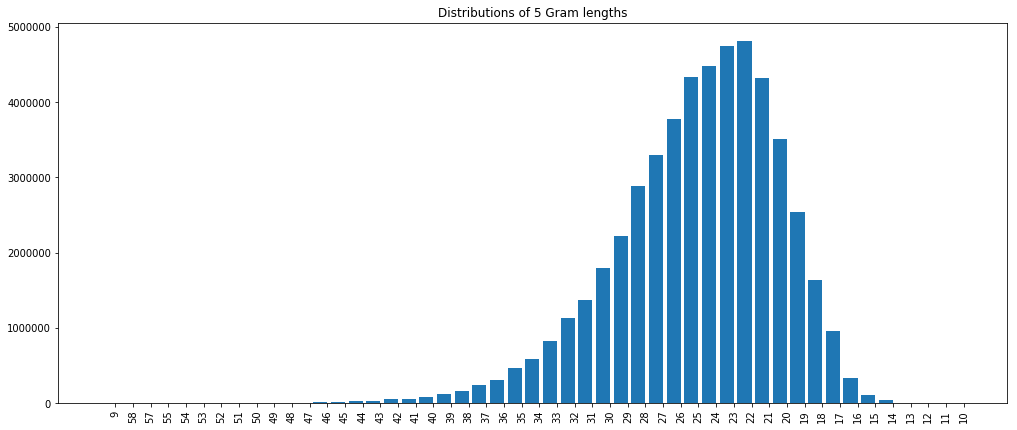

In [157]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("test_1.D.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

### HW5.6.2 - OPTIONAL: log-log plots (PHASE 2)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

# HW5.7 - Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3-5 plus some preprocessing)   

For the remainder of this assignment please feel free to eliminate stop words from your analysis (see stopWords in the cell below)

__A large subset of the Google n-grams dataset as was described above__

For each HW 5.6 - 5.7.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.


For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

In [ ]:
stopwords =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 's', 't', 'can', 'will', 'just', 
              'don', 'should', 'now']

### HW5.7.1 Running on 1 file

In [ ]:
# ADD CELLS AS NEEDED

### HW5.7.2 Running on 20 test files

In [ ]:
# ADD CELLS AS NEEDED

### HW5.7.3 Running the full dataset on Altiscale

Please contact the TAs for approval after obtaining results from 5.7.2. We have ran into issues in the past where the clusters froze because people did not test their code on a smaller dataset.

In [ ]:
# ADD CELLS AS NEEDED

#### Pretty print results
NOTE: depending on how you processed the stop words your results may differ from the table provided. 

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )


In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

# HW5.8 - Evaluation of synonyms that your discovered

In this part of the assignment you will evaluate the success of you synonym detector. Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.7, and use the synonyms function from the wordnet synonnyms list from the nltk package (see provided code below).

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("sims2/top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

# HW5.9 - OPTIONAL: using different vocabulary subsets

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

# HW5.10  - OPTIONAL 

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

# HW5.11 - OPTIONAL 

Once again, benchmark your top 10,000 associations (as in 5.7), this time for your
results from 5.8. Has your detector improved?